In the previous session, we discussed and implemented a CNN model from scratch. In this session, we will be focussion mostly on implementing an Image Classification Pipeline using Convolutional Layers, specifically the [LeNet-5](http://yann.lecun.com/exdb/lenet/) for the [MNIST dataset](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

The LeNet architecture is described in the image below:
![](https://github.com/SanVik2000/EE5179/blob/main/Tutorial-6/lenet5.png?raw=1)

Once the model is trained and evaluated on MNIST, we will have a short look at what the model has learned. As always, we'll import the modules we need...

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

...set the random seed for reproducability...

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

...and calculate the mean and standard deviation across our training set so we can normalize our data.

In [3]:
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


Then, we'll define our train and test transforms...

In [4]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

...load our train and test data...

In [5]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

...and create a validation set from 10% of our training data.

Remember that the validation set should always be taken from the training data, and never the test data.

In [6]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

The validation set is using the same transforms as the training set, as it was created from it. As we want our validation set to remain static, to better resemble our test set, we replace these with the test transforms - remembering to `deepcopy` the validation set.

In [7]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

We'll print out the number of examples in the training/validation/test sets to ensure everything has been loaded correctly.

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


The final part of the data processing stage is to create our dataloaders/iterators.

Again, we use a batch size of 64 and only shuffle the training data each epoch.

In [9]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

### Defining the Model

Each convolutional layer has a number of *filters*, also commonly referred to as *kernels*. A filter is a (usually) square matrix that slides across the pixels in an image from left-to-right, top-to-bottom. At each "step", the filter performs a [convolution](https://en.wikipedia.org/wiki/Convolution) operation on the image. The output of the convolutional layer is the result of these convolutions after the filter's final "step". 

**Note:** in machine learning frameworks there aren't actually "steps", the result for every filter location is calculated at the same time, in parallel. This is a lot faster than actually stepping through the image, but thinking about it in terms of steps makes everything easier to visualize.

Let's have a look at a single 2x2 filter passing over an image. We'll pretend the image is 10x10 pixels in this example.

![](https://github.com/SanVik2000/EE5179/blob/main/Tutorial-6/filter-mnist.png?raw=1)

![](https://github.com/SanVik2000/EE5179/blob/main/Tutorial-6/single-filter.png?raw=1)

The same weights are used by the filter over the whole image. The weights do not change depending on the filter's location within the image. One nice thing about this is that the filters (and the convolutional layers themselves) are *translation invariant*, that means it doesn't matter where a feature (curve, edge, line) appears in an image, the convolutional layer will find all occurrences of it. 


In [10]:
def plot_filter(images, filter):

    images = images = torch.cat([i.unsqueeze(0) for i in images],
                                dim=0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()

    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    fig = plt.figure(figsize=(20, 5))

    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title('Filtered')
        ax.axis('off')

We'll then get a batch of images to test our handwritten Sobel filters on. We get the images from the test set, as they're easier to examine without the transforms applied to them.

In [11]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

The first filter is for detecting horizontal lines.

We can see on the filtered images that the highest values (the whitest pixels) of the filtered image are where there is a horizontal line that is black on top and white below, e.g. the top of the 7 digit. The lowest values (the blackest pixels) of the filtered image are where there is a horizontal line that goes from white to black, e.g. the bottoms of all the digits.

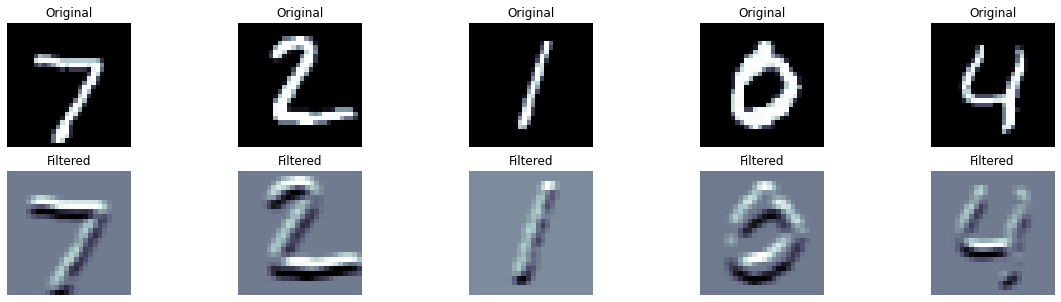

In [12]:
horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

By swapping the first and last rows of the above filter, we get a filter that detects horizontal lines from white on top to black underneath.

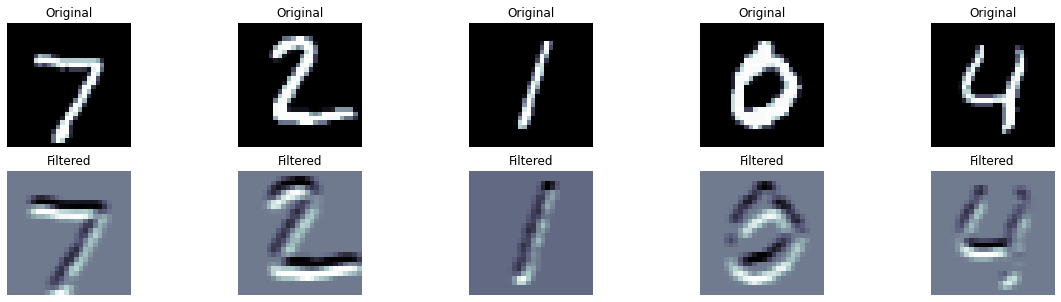

In [13]:
horizontal_filter = [[ 1,  2,  1],
                     [ 0,  0,  0],
                     [-1, -2, -1]]

plot_filter(images, horizontal_filter)

We can also design filters that detect vertical lines. 

Here's one that detects vertical lines that are black on the left and white on the right.

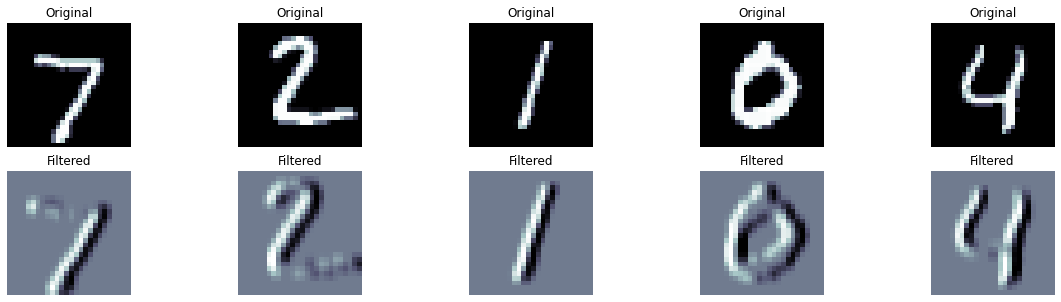

In [14]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

To get the opposite filter, one that detects vertical lines that are white on the left and black on the right, we swap the left and right columns.

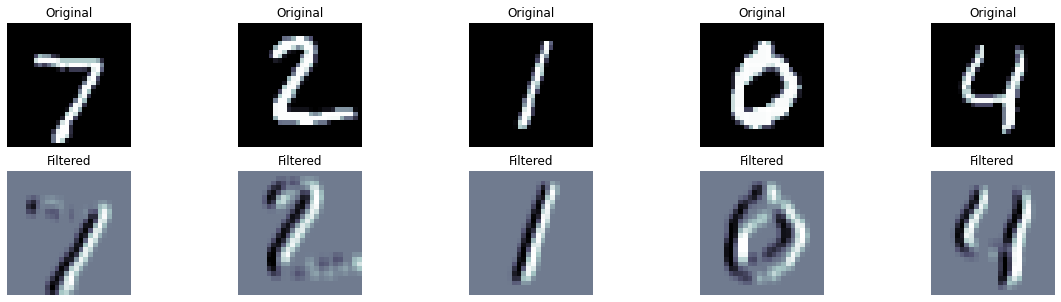

In [15]:
vertical_filter = [[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]]

plot_filter(images, vertical_filter)

Finally, we'll design a diagonal detecting filter. This one detects lines pointing towards the top right of the image.

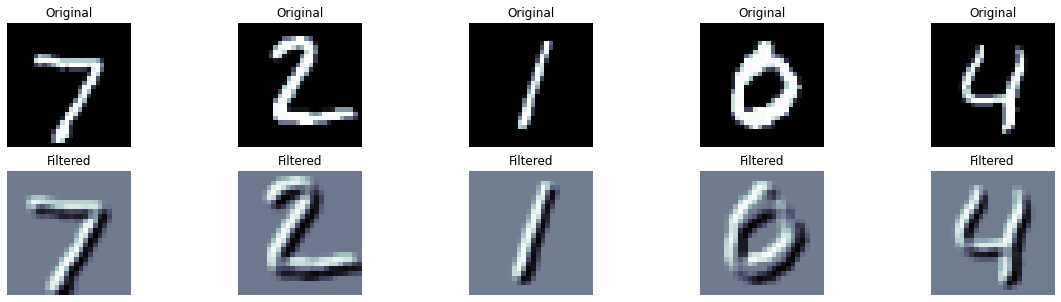

In [16]:
diagonal_filter = [[-2, -1, 0],
                   [-1,  0, 1],
                   [ 0,  1, 2]]

plot_filter(images, diagonal_filter)

The great thing about convolutional layers is that each layer doesn't just have a single filter. It has as many filters as you want. Each filter has their own set of weights, so (in theory) is learning to extract different features. 

The image below shows what happens when we use a convolutional layer with five filters. The original image with a single color channel (as it's black and white) has five filters applied to it to get five filtered images. These images are then stacked together to get what we can think of as a single image with five channels.  

![](https://github.com/SanVik2000/EE5179/blob/main/Tutorial-6/multiple-filter-mnist.png?raw=1)

Next, we'll talk about the subsampling layers. These are layers used to reduce the size/resolution of their input and are commonly applied to the output of convolutional layers. The most common two methods of subsampling are *max pooling* and *mean pooling* (also known as *average pooling*), and thus subsampling is often know as *pooling*.

Why do we want to reduce the resolution of the image? It speeds up our model, as convolution operations are expensive. If we subsample and half the size of our image before it passes into the next convolutional layer, that's a significant speed-up.

Subsampling layers aren't too different to convolutional layers. They have a filter with a size and a stride. However, pooling layers do not have any parameters - weights and biases. They simply perform an operation on the image. Max pooling returns the maximum of the values covered by the filter, and we can think of it as extracting the single most important feature under the filter. Mean/average pooling returns the mean/average of the values covered by the filter and we can think of it as equally weighting all features under the filter.



In [17]:
def plot_subsample(images, pool_type, pool_size):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()

    if pool_type.lower() == 'max':
        pool = F.max_pool2d
    elif pool_type.lower() in ['mean', 'avg']:
        pool = F.avg_pool2d
    else:
        raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')

    n_images = images.shape[0]

    pooled_images = pool(images, kernel_size=pool_size)

    fig = plt.figure(figsize=(20, 5))

    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        image = pooled_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title('Subsampled')
        ax.axis('off')

First, let's see max pooling with a filter size of 2. 

We can see that the image is heavily downsampled - reduced in size/resolution and in quality.

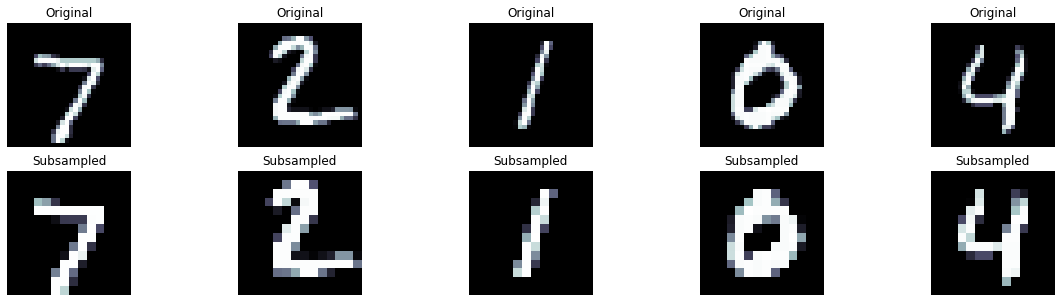

In [18]:
plot_subsample(images, 'max', 2)

If we increase the size of the max pooling filter, the images get smaller and the quality gets worse.

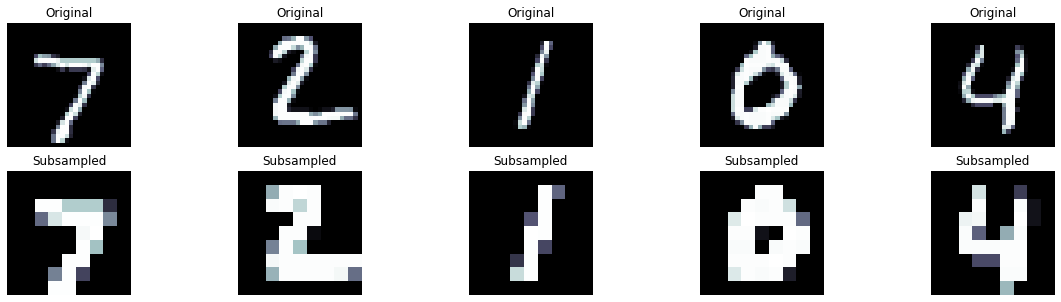

In [19]:
plot_subsample(images, 'max', 3)

For average pooling, the same effect happens, however the loss in quality is not as harsh.

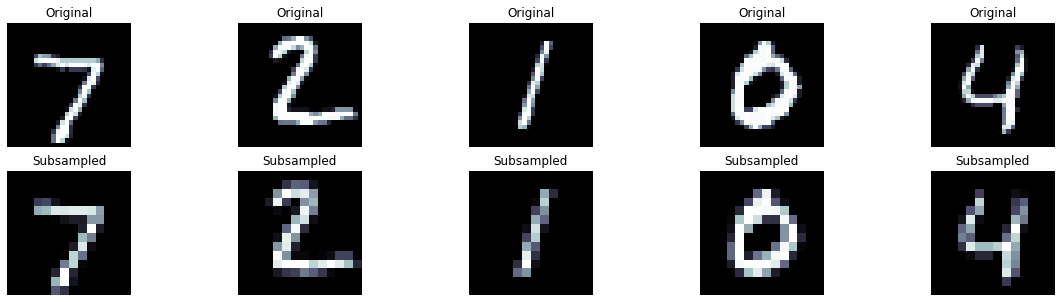

In [20]:
plot_subsample(images, 'avg', 2)

Again, we can increase the filter size, reducing the resolution of the output image at the cost of image quality - however, the quality drop is not as bad as max pooling.

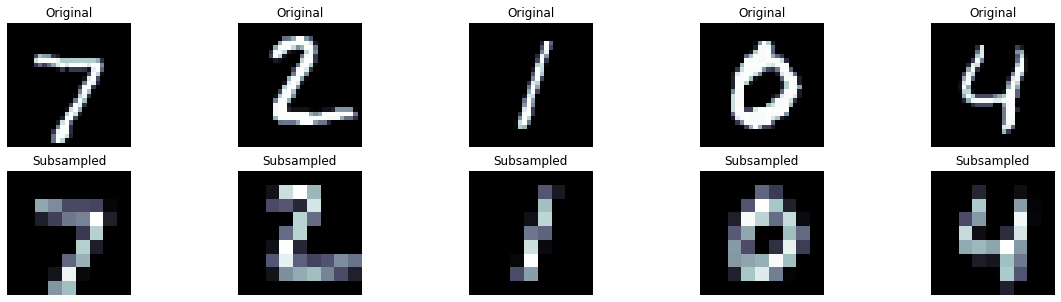

In [21]:
plot_subsample(images, 'avg', 3)

### Defining the Model

In [15]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=6,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        self.fc_1 = nn.Linear(16 * 4 * 4, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):

        # x = [batch size, 1, 28, 28]

        x = self.conv1(x)

        # x = [batch size, 6, 24, 24]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 6, 12, 12]

        x = F.relu(x)

        x = self.conv2(x)

        # x = [batch size, 16, 8, 8]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 16, 4, 4]

        x = F.relu(x)

        x = x.view(x.shape[0], -1)

        # x = [batch size, 16*4*4 = 256]

        h = x

        x = self.fc_1(x)

        # x = [batch size, 120]

        x = F.relu(x)

        x = self.fc_2(x)

        # x = batch size, 84]

        x = F.relu(x)

        x = self.fc_3(x)

        # x = [batch size, output dim]

        return x, h

In [16]:
OUTPUT_DIM = 10

model = LeNet(OUTPUT_DIM)

...and calculate the number of parameters. 

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 44,426 trainable parameters


In [18]:
optimizer = optim.Adam(model.parameters())

In [19]:
criterion = nn.CrossEntropyLoss()

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
model = model.to(device)
criterion = criterion.to(device)

In [22]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [23]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [24]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [25]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [26]:
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 34s
	Train Loss: 0.418 | Train Acc: 86.46%
	 Val. Loss: 0.117 |  Val. Acc: 96.42%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 32s
	Train Loss: 0.137 | Train Acc: 95.70%
	 Val. Loss: 0.081 |  Val. Acc: 97.68%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 33s
	Train Loss: 0.101 | Train Acc: 96.79%
	 Val. Loss: 0.074 |  Val. Acc: 97.76%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 32s
	Train Loss: 0.084 | Train Acc: 97.42%
	 Val. Loss: 0.063 |  Val. Acc: 98.19%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 0.069 | Train Acc: 97.80%
	 Val. Loss: 0.056 |  Val. Acc: 98.40%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 32s
	Train Loss: 0.066 | Train Acc: 97.93%
	 Val. Loss: 0.057 |  Val. Acc: 98.44%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 31s
	Train Loss: 0.060 | Train Acc: 98.14%
	 Val. Loss: 0.051 |  Val. Acc: 98.49%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 32s
	Train Loss: 0.053 | Train Acc: 98.32%
	 Val. Loss: 0.046 |  Val. Acc: 98.72%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 32s
	Train Loss: 0.052 | Train Acc: 98.39%
	 Val. Loss: 0.051 |  Val. Acc: 98.64%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 32s
	Train Loss: 0.048 | Train Acc: 98.46%
	 Val. Loss: 0.048 |  Val. Acc: 98.70%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 32s
	Train Loss: 0.047 | Train Acc: 98.54%
	 Val. Loss: 0.051 |  Val. Acc: 98.51%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 31s
	Train Loss: 0.044 | Train Acc: 98.65%
	 Val. Loss: 0.048 |  Val. Acc: 98.75%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 33s
	Train Loss: 0.041 | Train Acc: 98.67%
	 Val. Loss: 0.048 |  Val. Acc: 98.71%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 32s
	Train Loss: 0.040 | Train Acc: 98.71%
	 Val. Loss: 0.044 |  Val. Acc: 98.90%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 33s
	Train Loss: 0.040 | Train Acc: 98.73%
	 Val. Loss: 0.038 |  Val. Acc: 99.05%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 32s
	Train Loss: 0.035 | Train Acc: 98.88%
	 Val. Loss: 0.050 |  Val. Acc: 98.70%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 32s
	Train Loss: 0.036 | Train Acc: 98.92%
	 Val. Loss: 0.038 |  Val. Acc: 98.89%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 33s
	Train Loss: 0.035 | Train Acc: 98.87%
	 Val. Loss: 0.035 |  Val. Acc: 99.01%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 33s
	Train Loss: 0.033 | Train Acc: 98.97%
	 Val. Loss: 0.039 |  Val. Acc: 98.96%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 33s
	Train Loss: 0.033 | Train Acc: 98.98%
	 Val. Loss: 0.039 |  Val. Acc: 98.80%


In [28]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.023 | Test Acc: 99.31%


### Examining the Model

We'll examine our model by: plotting a confusion matrix, seeing which incorrect examples our model was most confident about, view our model's learned representations in two dimensions with t-SNE, and view the weights of our model.

First, we'll get the model's predictions across the test set...

In [29]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [30]:
images, labels, probs = get_predictions(model, test_iterator, device)

In [31]:
pred_labels = torch.argmax(probs, 1)

In [32]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

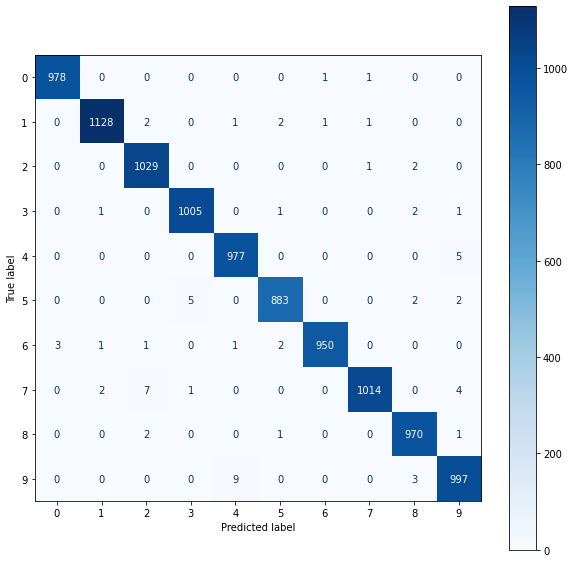

In [33]:
plot_confusion_matrix(labels, pred_labels)

In [34]:
corrects = torch.eq(labels, pred_labels)

In [36]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

In [37]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

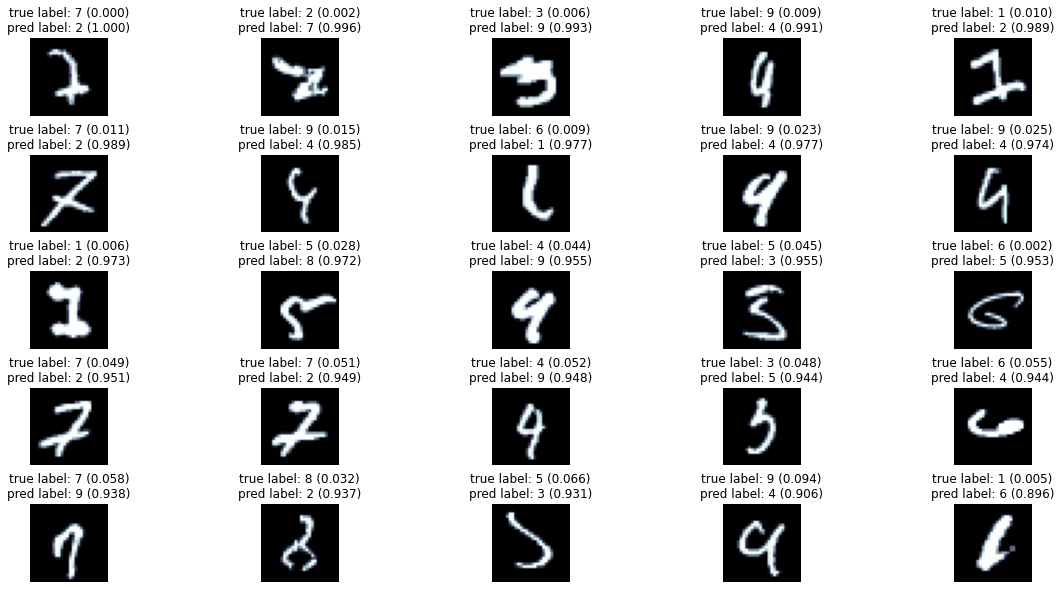

In [38]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

Let's move on to plotting the model's representations in lower dimensions, so we can visualize them.

First, we'll get the representations from the model...

In [39]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [40]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/844 [00:00<?, ?it/s]

Lets plot the T-SNE features...

In [41]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

In [43]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

First, the output representations. t-SNE does a good job on separating out the classes.

/home/sanvik/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sanvik/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


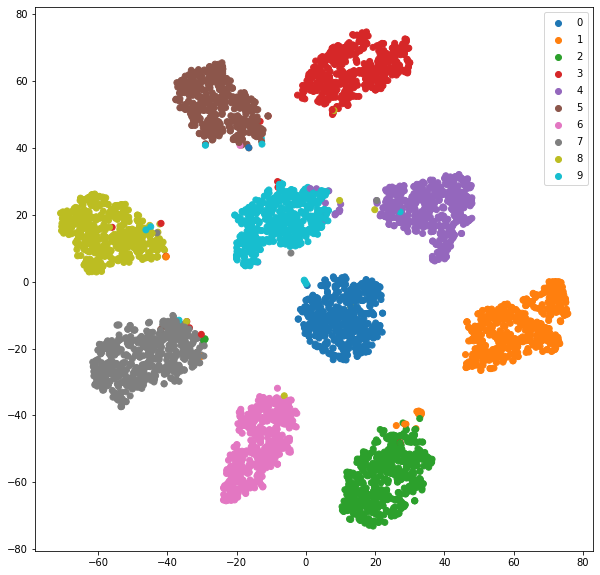

In [44]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

The intermediate representations are more clustered, which adds more evidence to the theory that this is just a representation of the extracted features before the linear layers have had a chance to weight up evidence on the presence or absence of certain extracted features.

/home/sanvik/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sanvik/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


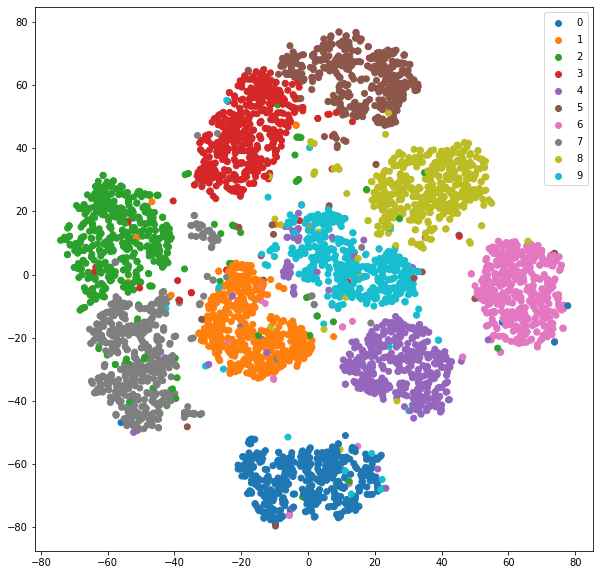

In [45]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

Remember how we defined the filters early on in this tutorial? Well, as convolutional layers learn their own values for their filters, we can do the same thing and see how our filters process images.

Let's define a function that takes a batch of images and multiple filters, which it then uses on the images.

In [46]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_images):

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

Some of our filters look for areas of black pixels, which has the effect of inverting our images. Some apply a blur effect, which is similar to [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur) effects used in image processing to reduce noise in the image. Some detect edges, like our Sobel filters we created earlier.

There is no guarantee each filter will learn a unique filtering effect. They are initialized randomly, and some filters may learn very similar weights. Therefore, it does not necessarily mean that using more filters will give a better performance.

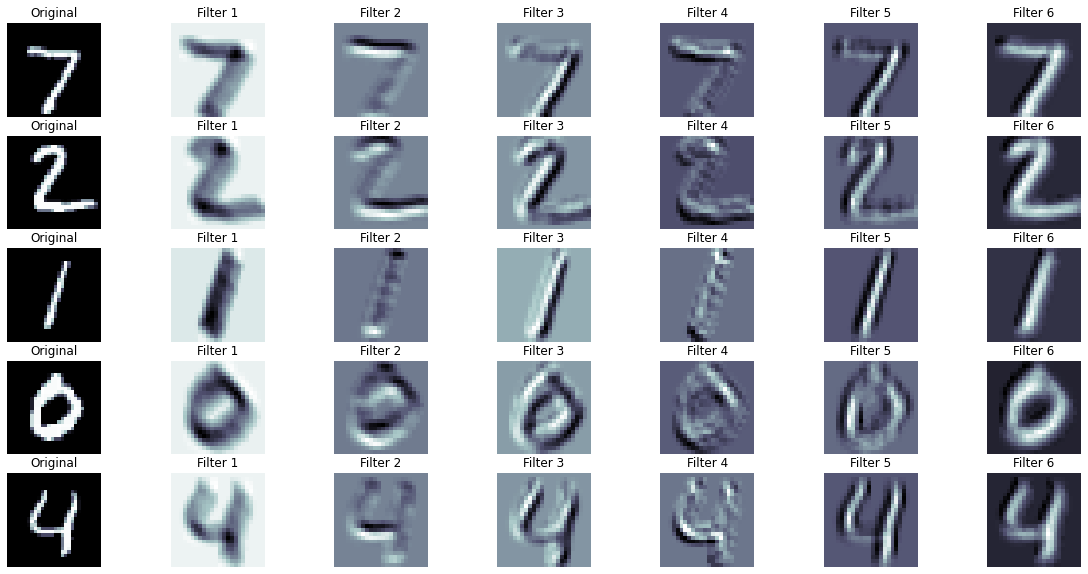

In [47]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters)

### Conclusions

In this notebook we have shown: 
- loading Torchvision datasets
- loading transforms to augment and normalize our data
- what a convolutional layer is doing
- what a subsampling layer is doing
- defining a CNN (LeNet)
- training a model to achieve >98% accuracy
- viewing our model's mistakes
- visualizing our data in lower dimensions with t-SNE
- viewing the learned weights of our model

As part of the tutorial-assignment, you will implement another CNN, AlexNet, and perform all the experiments similar to this notebook and explain your observations.